In [109]:
using ModelingToolkit, Plots, DifferentialEquations
using OrdinaryDiffEq
using Symbolics
mtk = ModelingToolkit
import ThermalSystem_Models as tsm

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


In [28]:
#= Ports =#
@variables t
const D = Differential(t)

function thermal_dof(name)
    @variables T(t)=300  [description = "Temperature (K)"]
    @variables ds(t)=0.0 [description = "Entropy Flow Rate = dS/dt W/K"]
    ODESystem(Equation[], t,[T,ds],[]; name = name)
end

function mechanical_dof(name)
    @variables P(t)=101325  [description = "Pressure, (Pa)"]
    @variables dV(t)=0.0    [description = "Volume flow rate, m^3/s, = v*A"]
    ODESystem(Equation[], t,[P,dV],[]; name = name)
end

function shaft_dof(name)
    @variables τ(t) = 0.0 [description = "Shaft torque Nm"]
    @variables ω(t) = 0.0 [description = "angular velocity (rad/s)"]
end

function energy_dof(name)
    @variables dE(t) = 0 [description = "Energy Rate (W)"]
    ODESystem(Equation[], t,[dE],[]; name = name)
end

function signal_dof(name)
    @variables sig(t) = 0   [description = "Signal (unitless)"]
    ODESystem(Equation[], t,[sig],[]; name = name)
end



flowConnect (generic function with 1 method)

### Equation generators

In [41]:

function eConnect(pins...)
    eqns = [sum(pin -> pin.dE, pins) ~ 0.0]
end

function thermalConnect(pins...)
    eqs = [
        sum(pin -> pin.ds, pins) ~ 0.0, # Entropy flow rate
    ]
    for pin in pins[2:end]
        push!(eqs, pins[1].T ~ pin.T)   # p_1 = p_2, p_1 = p_3,...
    end
    eqs
end

function flowConnect(pins...)
    eqs = [
        sum(pin -> pin.dV, pins) ~ 0.0, # Entropy flow rate
]
    for pin in pins[2:end]
        push!(eqs, pins[1].P ~ pin.P)   # p_1 = p_2, p_1 = p_3,...
    end
    eqs
end

function flowCap(pins...)
    eqs = [p.dV ~ 0 for p in pins]
end

flowCap (generic function with 1 method)

In [207]:
# Energy to thermal dof transformer
function e2mech_transformer(name)
    e = energy_dof(:e)  # (+) e.De = energy into the system
    p = mechanical_dof(:p)
    eqs = [e.dE ~ q.P * q.dV]
    compose(ODESystem(eqs, t,[],[]; name = name),e,q)
end

# Energy to shaft power
function e2shaft_tranformer(name)
    e     = energy_dof(:e)  # (+) e.De = energy into the system
    sh = shaft_dof(:shaft)      
    eqs = [e.dE ~ sh.τ * sh.ω]
    compose(ODESystem(eqs, t,[],[]; name = name),e,sh)
end

# constant energy flow source
function ConstantEnergyFlowSource(name; eflow)
    e = energy_dof(:e)
    eqs = [e.dE ~ -eflow]
    compose(ODESystem(eqs,t,[],[]; name = name),e)
end

function FluidGround(name; pressure = 101325)
    p = mechanical_dof(:p)
    eqs = [p.P ~ pressure]
    compose(ODESystem(eqs, t,[],[]; name = name), p)
end

function IsothermalGasRigidVolume(name; Rg = 287.06, 
                                        volume = 10,
                                        temperature = 300)
    # Rg = specific gas constant
    @variables P(t) = 101325                         [description = "Pressure, Pa"]
    @variables m(t) = 101325*volume/Rg/temperature   [description = "Mass of fluid stored in volume (kg)"]
    @parameters V = volume                           [description = "Container volume (m^3)"]
    @parameters T = temperature                      [description = "Temperature"]
    @parameters Rg = Rg                              [description = "Gas constant"]
    
    p = mechanical_dof(:p)
    C = V/(Rg*T)

    eqs = [D(m) ~ C*D(P),
            p.P ~ P,
            D(m) ~ p.dV* p.P/Rg*T]
    compose(ODESystem(eqs, t, [P,m], [V,T,Rg],name = name), p)
end

function IsothermalGasRigidControlVolume(name; Rg = 287.06, 
                                                volume = 10,
                                                temperature = 300)
        # Rg = specific gas constant
        @variables P(t) = 101325                         [description = "Pressure, Pa"]
        @variables m(t) = 101325*volume/Rg/temperature   [description = "Mass of fluid stored in volume (kg)"]
        @parameters V = volume                           [description = "Container volume (m^3)"]
        @parameters T = temperature                      [description = "Temperature"]
        @parameters Rg = Rg                              [description = "Gas constant"]

        p = mechanical_dof(:p)
        n = mechanical_dof(:n)

        C = V/(Rg*T)

        eqs = [p.P ~ P,
                n.P ~ P,
                D(m) ~ p.dV* p.P/Rg/T + n.dV * n.P/Rg/T,
                D(m) ~ C * D(P)]

        compose(ODESystem(eqs, t, [P,m], [V,T,Rg],name = name), p,n)
end

function IsothermalGasFlowResistance(name; R = 1.0)
    p = mechanical_dof(:p)
    n = mechanical_dof(:n)
    @parameters R = R
    eqs = [p.dV ~ (p.P - n.P)/R,
           0 ~ p.dV + n.dV]S
    compose(ODESystem(eqs, t, [], [R], name = name), p,n)
end

function pointMass(name; mass = 1.0, specific_heat = 10)
    @parameters m=mass cp=specific_heat
    C = m * cp
    q = thermal_dof(:q);
    eqs = [D(q.T) ~ (q.T * q.ds)/ C]
    compose(ODESystem(eqs, t, [], [m,cp],name = name), q)
end

function thermalResistor(name; UA = 1.0)
    @parameters R=1/UA

    qi = thermal_dof(:qi)
    qo = thermal_dof(:qo)

    eqs = [ qi.T*qi.ds ~ 1/R * (qi.T - qo.T),
            0 ~ qo.T*qo.ds +  qi.T*qi.ds]
    compose(ODESystem(eqs, t, [], [R], name = name), qi,qo)
end


IsothermalGasFlowResistance (generic function with 1 method)

### Filling accumulator

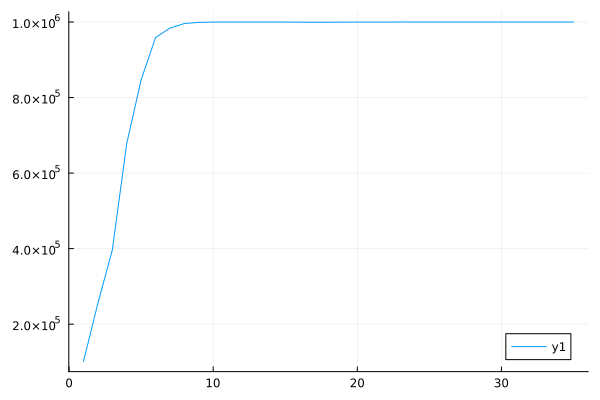

In [206]:
GasVol = IsothermalGasRigidVolume(:GasVol; temperature = 293, volume = 1)
GasRes = IsothermalGasFlowResistance(:GasRes; R = 1000)

conn = vcat(flowConnect(GasRes.n, GasVol.p),
            [GasRes.p.P ~ 1e6])


sysbuild = compose(ODESystem(conn, t, name = :sysbuild),
                    [GasRes,GasVol])
                    
sys = structural_simplify(sysbuild)
prob = ODEProblem(sys,[],(0,10))
sol = solve(prob)
plot(sol[sys.GasVol.p.P])
# plot(sol[sys.mass.q.T])


### Charging 2

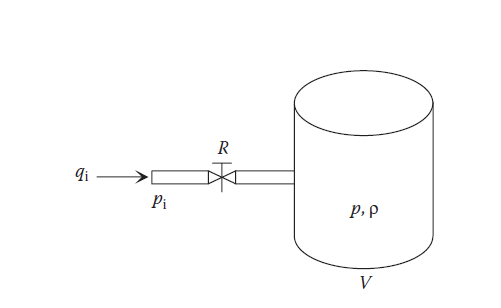

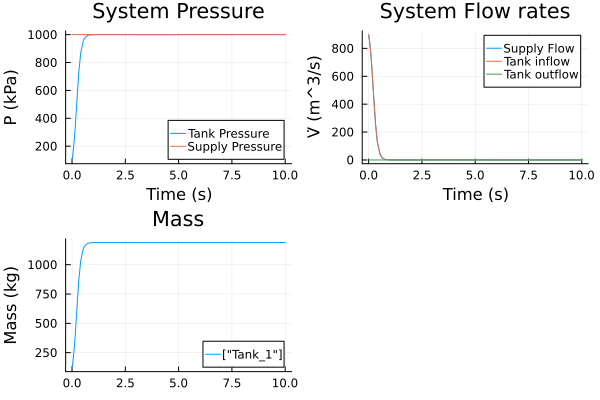

In [310]:
Tank1 = IsothermalGasRigidControlVolume(:Tank1; temperature = 293, volume = 100)
Rflow = IsothermalGasFlowResistance(:Rflow; R = 1000)

subsys = [Tank1, Rflow]

conn = vcat(flowConnect(Rflow.n, Tank1.p),
                        [Rflow.p.P ~ 1e6],
                        flowCap(Tank1.n))

sysbuild = compose(ODESystem(conn, t, name = :sysbuild), subsys)
                    
sys = structural_simplify(sysbuild)
prob = ODEProblem(sys,[],(0,10))
sol = solve(prob)

pressure_fig = plot(sol.t, [sol[sys.Tank1.p.P] ./ 10^3, sol[sys.Rflow.p.P] ./10^3]; 
                    label=["Tank Pressure" "Supply Pressure"], 
                    title = "System Pressure", 
                    ylabel = "P (kPa)",
                    xlabel = "Time (s)")

vflow_fig = plot(sol.t, [sol[sys.Tank1.p.dV], sol[sys.Rflow.p.dV], sol[sys.Tank1.n.dV]]; 
                    label=["Supply Flow" "Tank inflow" "Tank outflow"], 
                    title = "System Flow rates", 
                    ylabel = "V̇ (m^3/s)",
                    xlabel = "Time (s)")

mplot = plot(sol.t,[(sol[Tank1.m])], label = ["Tank_1"], title = "Mass",
    ylabel = "Mass (kg)")

p = plot(pressure_fig,vflow_fig,mplot)

#### Double Charge

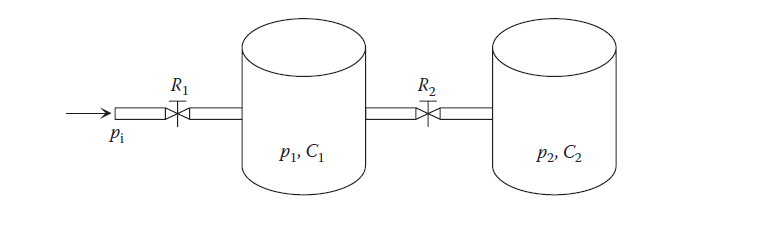

In [ ]:
Tank0 = IsothermalGasRigidControlVolume(:Tank1; temperature = 500, volume = 200)
Tank1 = IsothermalGasRigidControlVolume(:Tank2; temperature = 1000, volume = 100)
Tank2 = IsothermalGasRigidControlVolume(:Tank3; temperature = 500, volume = 200)
# Tank2 = IsothermalGasRigidVolume(:Tank2; temperature = 800, volume = 1000)
R1 = IsothermalGasFlowResistance(:R1; R = 5e6)
R2 = IsothermalGasFlowResistance(:R2; R = 4e6)

pfunc(x) = x.name
pfunc.(sysbuild.systems)

subsys = [Tank0,Tank1,Tank2,R1,R2]

conn = vcat(flowCap(Tank0.p),
            flowConnect(Tank0.n, R1.p),
            flowConnect(R1.n, Tank1.p),
            flowConnect(Tank1.n, R2.p),
            flowConnect(R2.n, Tank2.p),
            flowCap(Tank2.n))

sysbuild = compose(ODESystem(conn, t, name = :sysbuild), subsys)
   

u0P = [Tank0.P => 1.172109e+6,
        Tank1.P => 689475.7,
        Tank2.P => 1.172109e+6]
u0m =  [Tank0.m => u0[1][2] * Tank0.V/(Tank0.Rg * Tank0.T),
        Tank1.m => u0[2][2] * Tank1.V/(Tank1.Rg * Tank1.T),
        Tank2.m => u0[3][2] * Tank2.V/(Tank2.Rg * Tank2.T)]

u0 = vcat(u0P, u0m)

    
sys = structural_simplify(sysbuild)

prob = ODEProblem(sys,u0,(0,10000))

sol = solve(prob)

pa2k(x) = x./10^3;
v2gpm(x) = x .* 15850.37248375;


press_plot = plot(sol.t,[pa2k(sol[Tank0.P]),
                            pa2k(sol[Tank1.P]), 
                            pa2k(sol[Tank2.P])], 
                            label = ["Tank_0" "Tank_1" "Tank_2"], 
                            title = "Pressures",
                            ylabel = "(kPa)",
                            linewidth = 2.0,)

temp_plot = plot(sol.t,[(sol[R1.p.P] .- sol[R1.n.P])./10^3,
                        (sol[R2.p.P] .- sol[R1.n.P])./10^3] ,
                        label = ["R1 P drop" "R2 P drop"], 
                            title = "Resistance",
                            ylabel = "(kPa)",
                            linewidth = 2.0,)

rflow_plot = plot(sol.t,[v2gpm(sol[R1.p.dV]),
                        v2gpm(sol[R1.n.dV]),
                        v2gpm(sol[R2.p.dV]),
                        v2gpm(sol[R1.n.dV])] ,
                        label = ["inflow [R1]" "outflow [R1]" "inflow [R2]" "outflow [R2]"], 
                        title = "Resistance - flow",
                        ylabel = "(gpm)",
                        linewidth = 2.0,)

mplot = plot(sol.t,[(sol[Tank0.m]),
                    (sol[Tank1.m]), 
                    (sol[Tank2.m]), 
                    sol[Tank0.m] .+ sol[Tank1.m] .+ sol[Tank2.m]], 
                    label = ["Tank_0" "Tank_1" "Tank_2" "System"], 
                    title = "Mass",
                    ylabel = "Mass (kg)",
                    linewidth = 2.0)

fplot = plot(sol.t,[v2gpm(sol[Tank0.p.dV]),
                    v2gpm(sol[Tank1.p.dV]), 
                    v2gpm(sol[Tank1.n.dV]),
                    v2gpm(sol[Tank2.p.dV])], 
                    linewidth = 2.0,
                    label = ["Tank_0" "Tank_1_in" "Tank_1_out" "Tank_2"], 
                    title = "Flow Rates",
                    ylabel = "Gpm")

p=plot(press_plot,mplot,fplot,temp_plot, rflow_plot)
# plot(rflow_plot)
# plot(sol.t,sol[Tank1.p.P] .- sol[Tank2.p.P])

In [309]:
#=
                                    -- R2 -- Tank2 -- R4 --
    Flow Feed -> Tank0 -- R0 -- <                        > -- R5 -- Tank3
                                    -- R1 -- Tank1 -- R3-- 
=#
Tank0 = IsothermalGasRigidControlVolume(:Tank0; temperature = 500, volume = 200)

Tank1 = IsothermalGasRigidControlVolume(:Tank1; temperature = 500, volume = 200)

Tank2 = IsothermalGasRigidControlVolume(:Tank2; temperature = 500, volume = 500)

Tank3 = IsothermalGasRigidControlVolume(:Tank3; temperature = 500, volume = 200)

R0 = IsothermalGasFlowResistance(:R0; R = 5e6)

R1 = IsothermalGasFlowResistance(:R1; R = 5e6)

R2 = IsothermalGasFlowResistance(:R2; R = 4e6)

R3 = IsothermalGasFlowResistance(:R3; R = 5e6)

R4 = IsothermalGasFlowResistance(:R4; R = 4e6)

R5 = IsothermalGasFlowResistance(:R5; R = 5e6)


qfeed(t) = .005 * sin(.1 * t)^2

@register qfeed(t)
subsys = [Tank0,Tank1,Tank2, Tank3, R0, R1,R2,R3,R4,R5]

conn = vcat(Tank0.n.dV ~ -qfeed(t),
            flowCap(Tank3.n),
            flowConnect(Tank0.n, R0.p),
            flowConnect(R0.n, R1.p, R2.p),
            flowConnect(R1.n, Tank1.p), 
            flowConnect(Tank1.n, R3.p),
            flowConnect(R2.n, Tank2.p), 
            flowConnect(Tank2.n, R4.p), 
            flowConnect(R3.n, R4.n, R5.p),
            flowConnect(R5.n, Tank3.p))

sysbuild = compose(ODESystem(conn, t, name = :sysbuild), subsys)
   

u0P = [Tank0.P => 1.172109e+6,
        Tank1.P => 60e5,
        Tank2.P => 100e5,
        Tank3.P => 689475.7]


u0m =  [Tank0.m => u0[1][2] * Tank0.V/(Tank0.Rg * Tank0.T),
        Tank1.m => u0[2][2] * Tank1.V/(Tank1.Rg * Tank1.T),
        Tank2.m => u0[3][2] * Tank2.V/(Tank2.Rg * Tank2.T),
        Tank3.m => u0[4][2] * Tank3.V/(Tank3.Rg * Tank3.T)]

u0 = vcat(u0P, u0m)
sys = structural_simplify(sysbuild)
prob = ODEProblem(sys,u0,(0,1000))
sol = solve(prob)


tanks = [Tank0, Tank1, Tank2, Tank3];
Rvec  = [R0, R1, R2 ,R3, R4, R5]



press_plot = plot(sol.t,[pa2k(sol[tnk.P]) for tnk in tanks], 
                            label = ["Tank0" "Tank1" "Tank2" "Tank3"], 
                            title = "Pressures",
                            ylabel = "(kPa)",
                            linewidth = 2.0)

temp_plot = plot(sol.t,[(sol[Rii.p.P] .- sol[Rii.n.P])./10^3 for Rii in Rvec],
                            label =  ["R1" "R2" "R3" "R4" "R5" "FF"], 
                            title = "Resistance",
                            ylabel = "(kPa)",
                            linewidth = 2.0,)

rflow_plot = plot(sol.t,[v2gpm(sol[R1.p.dV]),
                        v2gpm(sol[R1.n.dV]),
                        v2gpm(sol[R2.p.dV]),
                        v2gpm(sol[R1.n.dV])] ,
                        label = ["inflow [R1]" "outflow [R1]" "inflow [R2]" "outflow [R2]"], 
                        title = "Resistance - flow",
                        ylabel = "(gpm)",
                        linewidth = 2.0,)

mplot = plot(sol.t,[(sol[Tank0.m]),
                    (sol[Tank1.m]), 
                    (sol[Tank2.m]), 
                    sol[Tank0.m] .+ sol[Tank1.m] .+ sol[Tank2.m]], 
                    label = ["Tank_0" "Tank_1" "Tank_2" "System"], 
                    title = "Mass",
                    ylabel = "Mass (kg)",
                    linewidth = 2.0)

fplot = plot(sol.t,[v2gpm(sol[Tank0.p.dV]),
                    v2gpm(sol[Tank1.p.dV]), 
                    v2gpm(sol[Tank1.n.dV]),
                    v2gpm(sol[Tank2.p.dV])], 
                    linewidth = 2.0,
                    label = ["Tank_0" "Tank_1_in" "Tank_1_out" "Tank_2"], 
                    title = "Flow Rates",
                    ylabel = "Gpm")

p=plot(press_plot,mplot,fplot,temp_plot, rflow_plot)
# plot(rflow_plot)
plot(sol.t,sol[Tank1.p.P] .- sol[Tank2.p.P])

ArgumentError: ArgumentError: SymbolicUtils.BasicSymbolic{Real}[Tank2₊p₊dVˍt(t)] are missing from the variable map.

In [296]:
sol[Tank1.p.dV]

26-element Vector{Float64}:
  0.010591323076923146
  0.01059132037105606
  0.010591293312387364
  0.010591022726008046
  0.010588316892932404
  0.010561261633673262
  0.010291015986945278
  0.007619051323123036
 -0.0063327142740884305
 -0.02581380753056529
  ⋮
 -0.05887923820155706
 -0.04075342116591929
 -0.023525173982222824
 -0.009616223301325203
 -0.0004131770898171345
  0.004439320531465309
  0.006420926035664099
  0.0065593715553722174
  0.006257824118504761

In [ ]:
 sys = structural_simplify(sysbuild)

prob = ODEProblem(sys,u0,(0,100))

sol = solve(prob)

pa2k(x) = x./10^3;
v2gpm(x) = x .* 15850.37248375;


press_plot = plot(sol.t,[pa2k(sol[Tank0.P]),pa2k(sol[Tank1.P]), pa2k(sol[Tank2.P])], label = ["Tank_0" "Tank_1" "Tank_2"], title = "Pressures",
                            ylabel = "Pressure (kPa)")

mplot = plot(sol.t,[(sol[Tank0.m]),(sol[Tank1.m]), (sol[Tank2.m]), sol[Tank0.m] .+ sol[Tank1.m] .+ sol[Tank2.m]], label = ["Tank_0" "Tank_1" "Tank_2" "System"], title = "Mass",
                        ylabel = "Mass (kg)")

fplot = plot(sol.t,[v2gpm(sol[Tank0.p.dV]),
                    v2gpm(sol[Tank1.p.dV]), 
                    v2gpm(sol[Tank1.n.dV]),
                    v2gpm(sol[Tank2.p.dV])], 
                    label = ["Tank_0" "Tank_1_in" "Tank_1_out" "Tank_2"], 



                        title = "Flow Rates",
                        ylabel = "Gpm")



plot(press_plot,mplot,fplot)
# plot(sol.t,sol[Tank1.p.P] .- sol[Tank2.p.P])


In [ ]:

pressure_fig = plot(sol.t, [sol[sys.Tank1.p.P] ./ 10^3, sol[sys.Rflow.p.P] ./10^3]; 
                    label=["Tank Pressure" "Supply Pressure"], 
                    title = "System Pressure", 
                    ylabel = "P (kPa)",
                    xlabel = "Time (s)")

vflow_fig = plot(sol.t, [sol[sys.Tank1.p.dV], sol[sys.Rflow.p.dV], sol[sys.Tank1.n.dV]]; 
                    label=["Supply Flow" "Tank inflow" "Tank outflow"], 
                    title = "System Flow rates", 
                    ylabel = "V̇ (m^3/s)",
                    xlabel = "Time (s)")

p = plot(pressure_fig,vflow_fig)

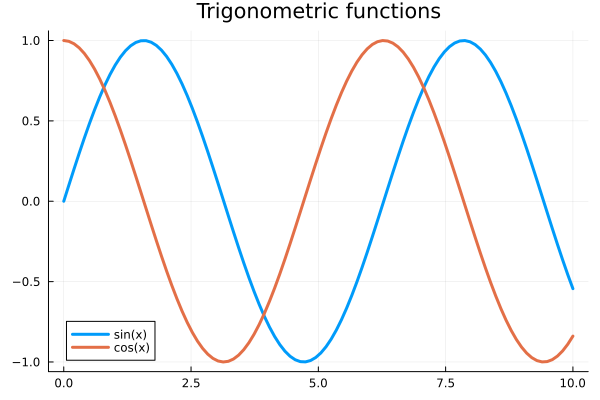

In [64]:
x = range(0, 10, length=100)
y1 = sin.(x)
y2 = cos.(x)
plot(x, [y1 y2], title="Trigonometric functions", label=["sin(x)" "cos(x)"], linewidth=3)

Connecting adjacent reservoirs

In [ ]:
Tank1 = IsothermalGasRigidVolume(:Tank1; temperature = 293, volume = 1)
Tank2 = IsothermalGasRigidVolume(:Tank2; temperature = 293, volume = 1)
Rflow = IsothermalGasFlowResistance(:Rflow; R = 1000)

conn = vcat(flowConnect(Tank1.n, GasVol.p),
            [GasRes.p.P ~ 1e6])


sysbuild = compose(ODESystem(conn, t, name = :sysbuild),
                    [GasRes,GasVol])
                    
sys = structural_simplify(sysbuild)
prob = ODEProblem(sys,[],(0,10))
sol = solve(prob)
plot(sol[sys.GasVol.p.P])

In [ ]:

function pointMass(name; mass = 1.0, specific_heat = 10)
    @parameters m=mass cp=specific_heat
    C = m * cp
    q = thermal_dof(:q);
    eqs = [D(q.T) ~ (q.T * q.ds)/ C]
    compose(ODESystem(eqs, t, [], [m,cp],name = name), q)
end

function thermalResistor(name; UA = 1.0)
    @parameters R=1/UA

    qi = thermal_dof(:qi)
    qo = thermal_dof(:qo)

    eqs = [ qi.T*qi.ds ~ 1/R * (qi.T - qo.T),
            0 ~ qo.T*qo.ds +  qi.T*qi.ds]
    compose(ODESystem(eqs, t, [], [R], name = name), qi,qo)
end


function eConnect(pins...)
    eqns = [sum(pin -> pin.dE, pins) ~ 0.0]
end

function thermalConnect(pins...)
    eqs = [
        sum(pin -> pin.ds, pins) ~ 0.0, # Entropy flow rate
    ]
    for pin in pins[2:end]
        push!(eqs, pins[1].T ~ pin.T)   # p_1 = p_2, p_1 = p_3,...
    end
    eqs
end